In [1]:
import numpy as np
import seaborn as sb
import pandas
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
import torch
import time
%matplotlib inline

# A quick intro to PyTorch

Based on [this excellent intro](https://github.com/jcjohnson/pytorch-examples/blob/master/README.md)

[PyTorch](https://github.com/pytorch/pytorch) is a high-level API to facilitate the construction and optimization of computational graphs. These graphs basically encode certain kinds of (connected, recurrent, subsequent) operations on so-called Tensors. Tensors are an extension to Matrices and in our case can simply be seen as multi-dimensional arrays with some linear algebra sauce added.

Importantly, we know that designing neural networks will require us to set up
- an architecture (layers)
- suitable activation functions (tanh, ReLU, etc)
- a loss function (our task)

Once we have done this, we need to differentiate the loss function by means of backpropagation to determine how each layer would update its weights given the error observed at the next layer downstream.

To facilitate this, PyTorch provides two main features:
- n-dimensional tensors that can run on **GPUs** (hence, fast!)
- automatic differentiation for building and training computational graphs (i.e., neural networks)

The following will use a fully-connected network with rectified linear units (ReLUs) as activation functions as the basic architecture. To make matters simple, we will only use one hidden layer (like in the previous example), and we will use gradient descent to fit some random data by minimizing the L2-distance between the network output and the desired  output.

**Note that this introduction is only that, it does not focus on deeper details of the pytorch library and only has bare-bones examples!**

## Warm-up: numpy

Let's quickly re-implement the 1-hidden-layer network from before using numpy.

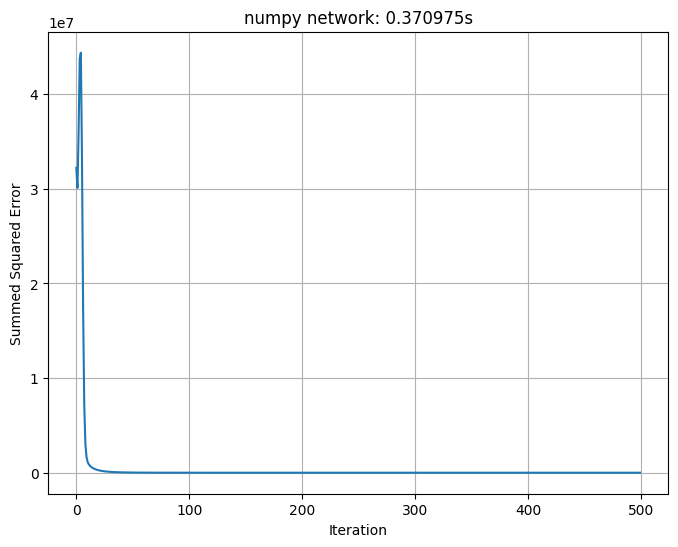

In [2]:
start=time.time()
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create normal random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6
max_iterations = 500
l2_errors = np.zeros(max_iterations)

for it in range(max_iterations):
    # Forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h,0)
    y_pred = h_relu.dot(w2)

    # Compute and print loss
    l2_errors[it] = np.square(y_pred-y).sum()

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

total_time = time.time()-start
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(l2_errors)
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('numpy network: {:0.6f}s'.format(total_time))
plt.grid()

## PyTorch: Tensors

Now, let's convert the code to make use of PyTorch tensors that can calculate on the GPU. For this, we make use of the `device` argument when constructing a tensor to either put it on the CPU (default) or on a specific GPU.

Let's reimplement the network using PyTorch commands - for most commands, this simply means to substitute ```numpy``` by ```torch``` and add the device!

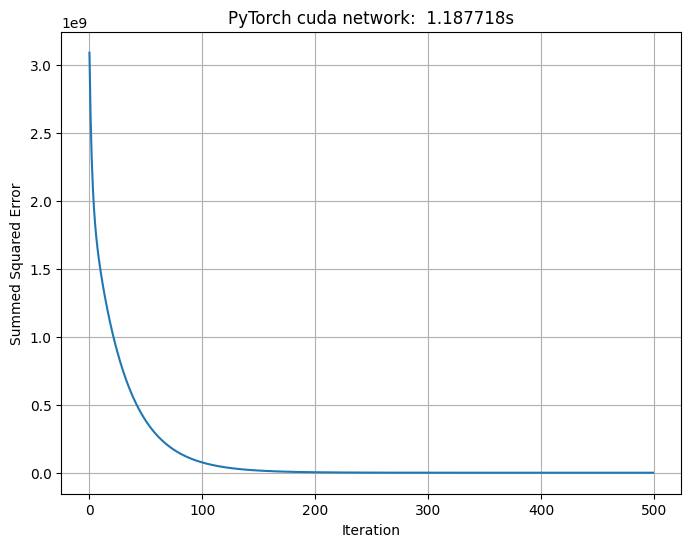

In [3]:
#if (torch.has_cuda): # do this for automatic switching

doGPU=True
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

start=time.time()
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 10000, 10

# Create normal random input and output data
# note, we simply substitute numpy by torch and add the device!
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device)
w2 = torch.randn(H, D_out, device=device)

learning_rate = 1e-9
max_iterations = 500
l2_errors = np.zeros(max_iterations)

for it in range(max_iterations):
    # Forward pass: compute predicted y
    # the dot-product here is called matrix multiplication "mm"
    h = x.mm(w1)
    # relu
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss; the loss is a scalar,
    # and is stored in a PyTorch Tensor
    # of shape (); we can get its value as a Python
    # number with loss.item().
    loss = (y_pred - y).pow(2).sum()
    l2_errors[it]=loss.item()

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

total_time = time.time()-start
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(l2_errors)
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('PyTorch {0:} network: {1: 0.6f}s'.format(device,total_time))
plt.grid()

del w1, w2

We can see that for a "small" network, numpy (or the CPU version of PyTorch) is comparable in terms of execution time to the GPU-version. This is because there is an overhead in sending the information to and from the GPU - this overhead, however, is completely negligible once larger networks (and with this, larger tensors) have to be handled.

## PyTorch: Autograd

Let's come to the second, big advantage of having a high-level API like PyTorch work for us: [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). We can use this to do the backpropagation of the error through the layers for us!

The **autograd** package in PyTorch provides this functionality, and with that will translate the layer architecture of the network and the loss function into a
**computational graph**. Nodes in the graph will be tensors, and edges will be functions that produce output Tensors from input Tensors. Once the graph has been formulated properly, automatic differentation can be used to derive the gradients for backpropagation.

If you therefore want to implement this using PyTorch, you specify `requires_grad=True`
 during the construction of the tensor. Then, as soon as you apply any **PyTorch operations** on that Tensor the
computational graph will be built, allowing us to do backpropagation. If `x` is a Tensor with `requires_grad=True`, then after
backpropagation another tensor `x.grad` will be added to it which contains the gradient of `x`.

Not all operations require the construction of the graph, however, for example weight updates during
training do **not** need to be derived even though they of course are PyTorch operations working on tensors! For this, specify `torch.no_grad()` for these operations to prevent the construction of a computational graph.

Let's implement this:

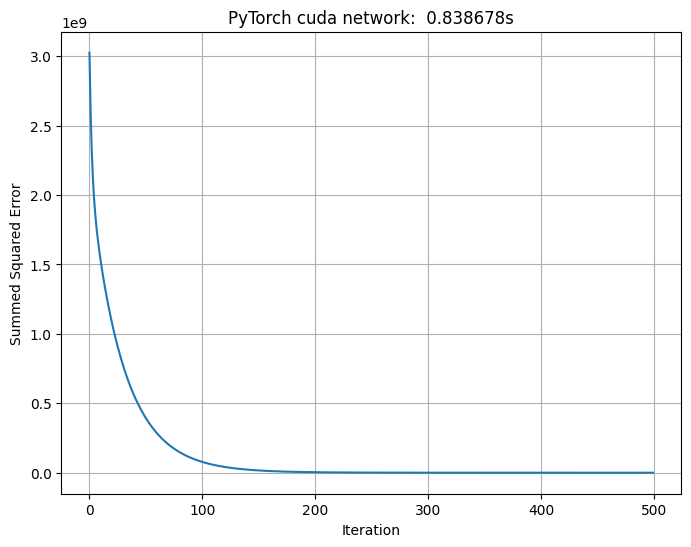

In [4]:
#if (torch.has_cuda): # do this for automatic switching

doGPU=True
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

start=time.time()

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 10000, 10

# Create random Tensors to hold input and outputs
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Create random Tensors for weights;
# setting requires_grad=True means that we
# want to compute gradients for these
# tensors during the backward pass.
# -- we of course do NOT want to calculate gradients
# for our data input and output tensors x,y!!
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

learning_rate = 1e-9
max_iterations = 500
l2_errors = np.zeros(max_iterations)

for it in range(max_iterations):
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss. Loss is a Tensor of shape (), and loss.item()
    # is a Python number giving its value.
    loss = (y_pred - y).pow(2).sum()
    l2_errors[it] = loss.item()

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Update weights using gradient descent. For this step we just want to mutate
    # the values of w1 and w2 in-place; we don't want to build up a computational
    # graph for the update steps, so we use the torch.no_grad() context manager
    # to prevent PyTorch from building a computational graph for the updates
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

    # Manually zero the gradients after running the backward pass
    w1.grad.zero_()
    w2.grad.zero_()

total_time = time.time()-start
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(l2_errors)
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('PyTorch {0:} network: {1: 0.6f}s'.format(device,total_time))
plt.grid()

del w1, w2, y_pred, loss

We note that there is a small overhead in terms of performance, when using the computational graph structure, as PyTorch needs to keep track of the gradients through the autograd functionality.

Since autograd passes basically require a forward and backward step, it is of course possible to code your own versions of these and use them instead - here, we are not going to do this, since we want to have it more convenient at the moment. We want PyTorch to do even more heavy lifting for us.

## PyTorch: nn
Computational graphs and autograd are a very powerful paradigm for defining
complex operators and automatically taking derivatives; however for large
neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation
into **layers**, some of which have **learnable parameters** which will be
optimized during learning.

In PyTorch, the `nn` package defines a set of
**Modules**, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as
Tensors containing learnable parameters. The `nn` package also defines a set of useful loss functions that are commonly used when training neural networks.

In this example we use the `nn` package to implement our two-layer network:

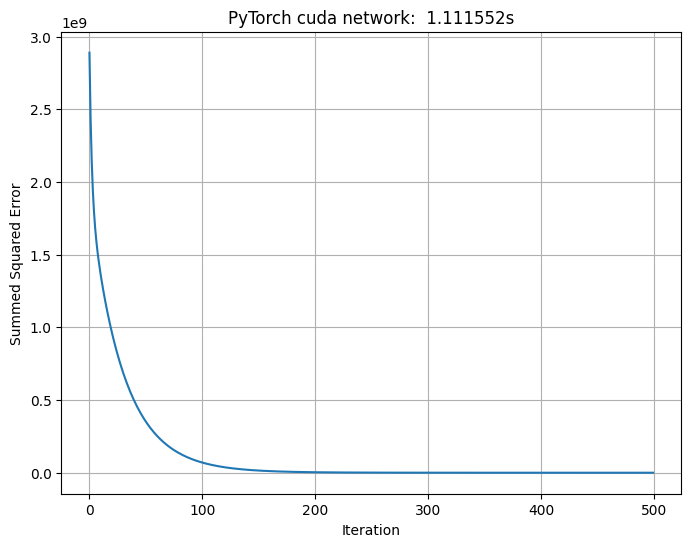

In [5]:
#if (torch.has_cuda): # do this for automatic switching

doGPU=True
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

start=time.time()

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 10000, 10

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# After constructing the model we use the .to() method to move it to the
# desired device.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        size = m.weight.size() # returns a tuple
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        m.weight.data = torch.randn(fan_out, fan_in, device=device)

model.apply(weights_init)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function. Setting
# reduction='sum' means that we are computing the *sum* of squared errors rather
# than the mean; this is for consistency with the examples above where we
# manually compute the loss, but in practice it is more common to use mean
# squared error as a loss by setting reduction='elementwise_mean'.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-9
max_iterations = 500
l2_errors = np.zeros(max_iterations)

for it in range(max_iterations):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)



    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_fn(y_pred, y)
    l2_errors[it] = loss.item()

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

total_time = time.time()-start
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(l2_errors)
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('PyTorch {0:} network: {1: 0.6f}s'.format(device,total_time))
plt.grid()

Note that once we have defined a model via the pytorch abstracted layers and have therefore constructed a computational graph, we can easily "print" a summary of the model via the overloaded print command in python

In [6]:
print(model)

Sequential(
  (0): Linear(in_features=1000, out_features=10000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10000, out_features=10, bias=True)
)


Using the torchviz helper package, we can get a deeper visualization of the full computational graph like so:

In [7]:
# x = torch.randn(512, 1000).requires_grad_(True).to(device)
# y = model(x)
# make_dot(y, params=dict(list(model.named_parameters()))).render("torchviz", format="png")
# %matplotlib inline
# plt.figure(figsize=(10,20))
# img = mpimg.imread('torchviz.png')
# plt.imshow(img)
# plt.show()

Using the newer [torchview](https://github.com/mert-kurttutan/torchview) package, this will look like so.

In [8]:
#!pip install graphviz
#!pip install torchview

In [9]:
# from torchview import draw_graph

# batch_size = 2
# # Show inner tensors and Functionals
# model_graph = draw_graph(
#     model, input_size=(2, 1000),
#     graph_name='One-Layer NN',
#     hide_inner_tensors=False,
#     hide_module_functions=False,
#     device='meta'
# )

# model_graph.visual_graph

## PyTorch: optim
Up to this point we have updated the weights of our models by manually mutating
Tensors holding learnable parameters. This is not a huge burden
for simple optimization algorithms like stochastic gradient descent, but in practice
we often train neural networks using more sophisiticated optimizers like AdaGrad,
RMSProp, Adam, etc.

The `optim` package in PyTorch abstracts the idea of an optimization algorithm and
provides implementations of commonly used optimization algorithms.

In this example we will use the `nn` package to define our model as before, but we
will optimize the model using the Adam algorithm provided by the `optim` package:

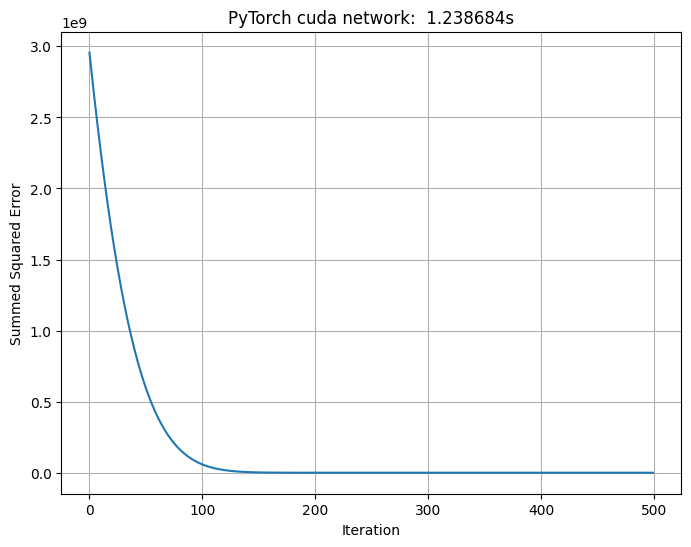

In [11]:
# only done to start fresh and to avoid issues with GPU and pytorch
del model

doGPU=True
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

start=time.time()

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 10000, 10

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        size = m.weight.size() # returns a tuple
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        m.weight.data = torch.randn(fan_out, fan_in, device=device)

model.apply(weights_init)

loss_fn = torch.nn.MSELoss(reduction='sum')

max_iterations = 500
l2_errors = np.zeros(max_iterations)

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for it in range(max_iterations):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    l2_errors[it] = loss.item()

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

total_time = time.time()-start
%matplotlib inline
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(l2_errors)
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('PyTorch {0:} network: {1: 0.6f}s'.format(device,total_time))
plt.grid()